## Eye State Classification from EEG


### Introduction


### Data Prep



In [8]:
# setting the random seed for reproducibility
import random
seed=42
random.seed(seed)

In [9]:
# import libraries 
import itertools
import requests
import os.path
import numpy as np
import pandas as pd
from scipy.io import arff
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

### Load the Data

In [10]:
# check if data file exists locally
if not os.path.isfile('EEG Eye State.arff'):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00264/EEG%20Eye%20State.arff'
    r = requests.get(url, allow_redirects=True)
    open('EEG Eye State.arff', 'wb').write(r.content)

# read data from local csv file
#df = pd.read_csv("EEGEyeState.csv", header=None)

# read data from local arff file
data = arff.loadarff('EEG Eye State.arff')
df = pd.DataFrame(data[0])

In [11]:
# reject NaN entries
df.dropna()

# insert columns names
df.columns = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'eyeDetection']

# remove outliers
df1 = df[df.loc[:, df.columns != 'eyeDetection'].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

# define data samples
X = df1.iloc[0:, 0:14].values

# standardize data
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_short = min_max_scaler.fit_transform(X)

# define target
y_short = df1.iloc[0:,14].values.astype(int)

unique, counts = np.unique(y_short, return_counts=True)
print(dict(zip(unique, counts)))

print(df.shape)
print(X_short,X_short.shape,'\n\n',
      y_short,y_short.shape)

{0: 8172, 1: 6720}
(14980, 15)
[[0.43315296 0.42978053 0.53914831 ... 0.44283486 0.52808589 0.51187141]
 [0.41794246 0.41065428 0.56628488 ... 0.43715177 0.51965054 0.48535451]
 [0.4280718  0.41915944 0.57527166 ... 0.4514152  0.50842166 0.49930648]
 ...
 [0.26227399 0.35319255 0.289163   ... 0.3171384  0.4072796  0.36402948]
 [0.2859641  0.35742439 0.31624082 ... 0.36856474 0.41993263 0.3947075 ]
 [0.29609344 0.38086545 0.36745962 ... 0.4085692  0.4241503  0.3947075 ]] (14892, 14) 

 [0 0 0 ... 1 1 1] (14892,)


### Model



In [12]:
# full dataset parameters

# define model parameters
samples = X_short.shape[0]  # how many trials of eeg data
n_features = X_short.shape[1]  # how many channels of eeg in each sample
time_steps = 1 # how many ms was each sample run for

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# use strat. shuffle split to get indices for test and training data 
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=seed)
sss.get_n_splits(X_short, y_short)

# take the indices generated by stratified shuffle split and make the test and training datasets
for train_index, test_index in sss.split(X_short, y_short):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_short[train_index], X_short[test_index]
    y_train, y_test = y_short[train_index], y_short[test_index]
    
X_train = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[1])
y_train = y_train.reshape(y_train.shape[0], time_steps)

X_test = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])
y_test = y_test.reshape(y_test.shape[0], time_steps)

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, TerminateOnNaN

model = Sequential()
model.add(GRU(28, return_sequences=True, 
               recurrent_regularizer=l1_l2(0.0001, 0.0001),
               input_shape=(time_steps, n_features)))
model.add(GRU(28, input_shape=(time_steps, n_features), 
               recurrent_regularizer=l1_l2(0.0001, 0.0001),
               return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(28, input_shape=(time_steps, n_features),
              recurrent_regularizer=l1_l2(0.0001, 0.0001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto')

terminate_NaN = TerminateOnNaN()

history = model.fit(X_train, y_train, validation_split=0.25, 
                    batch_size=28, epochs=1000, verbose=1, 
                    callbacks=[early_stop, terminate_NaN])

Train on 8934 samples, validate on 2979 samples
Epoch 1/1000
8934/8934 [==============================] - 6s 704us/step - loss: 0.6877 - acc: 0.5670 - val_loss: 0.7052 - val_acc: 0.5676
Epoch 2/1000
8934/8934 [==============================] - 3s 289us/step - loss: 0.6580 - acc: 0.6107 - val_loss: 0.6498 - val_acc: 0.6183
Epoch 3/1000
8934/8934 [==============================] - 3s 311us/step - loss: 0.6467 - acc: 0.6248 - val_loss: 0.6765 - val_acc: 0.5874
Epoch 4/1000
8934/8934 [==============================] - 3s 293us/step - loss: 0.6397 - acc: 0.6285 - val_loss: 0.6330 - val_acc: 0.6448
Epoch 5/1000
8934/8934 [==============================] - 3s 289us/step - loss: 0.6308 - acc: 0.6481 - val_loss: 0.6875 - val_acc: 0.5515
Epoch 6/1000
8934/8934 [==============================] - 3s 292us/step - loss: 0.6147 - acc: 0.6732 - val_loss: 0.6165 - val_acc: 0.6432
Epoch 7/1000
8934/8934 [==============================] - 3s 288us/step - loss: 0.5955 - acc: 0.6854 - val_loss: 0.5831 - va

8934/8934 [==============================] - 3s 389us/step - loss: 0.3766 - acc: 0.8283 - val_loss: 0.3927 - val_acc: 0.8154
Epoch 60/1000
8934/8934 [==============================] - 4s 429us/step - loss: 0.3736 - acc: 0.8303 - val_loss: 0.3631 - val_acc: 0.8342
Epoch 61/1000
8934/8934 [==============================] - 4s 400us/step - loss: 0.3792 - acc: 0.8306 - val_loss: 0.3568 - val_acc: 0.8442
Epoch 62/1000
8934/8934 [==============================] - 3s 388us/step - loss: 0.3722 - acc: 0.8367 - val_loss: 0.3530 - val_acc: 0.8432
Epoch 63/1000
8934/8934 [==============================] - 4s 397us/step - loss: 0.3697 - acc: 0.8337 - val_loss: 0.3597 - val_acc: 0.8402
Epoch 64/1000
8934/8934 [==============================] - 3s 339us/step - loss: 0.3681 - acc: 0.8361 - val_loss: 0.3549 - val_acc: 0.8429
Epoch 65/1000
8934/8934 [==============================] - 3s 338us/step - loss: 0.3633 - acc: 0.8364 - val_loss: 0.3508 - val_acc: 0.8453
Epoch 66/1000
8934/8934 [================

Epoch 118/1000
8934/8934 [==============================] - 4s 445us/step - loss: 0.3052 - acc: 0.8685 - val_loss: 0.2905 - val_acc: 0.8734
Epoch 119/1000
8934/8934 [==============================] - 4s 451us/step - loss: 0.2911 - acc: 0.8725 - val_loss: 0.3087 - val_acc: 0.8708
Epoch 120/1000
8934/8934 [==============================] - 4s 469us/step - loss: 0.3025 - acc: 0.8679 - val_loss: 0.2850 - val_acc: 0.8691
Epoch 121/1000
8934/8934 [==============================] - 4s 462us/step - loss: 0.2974 - acc: 0.8715 - val_loss: 0.2884 - val_acc: 0.8755
Epoch 122/1000
8934/8934 [==============================] - 4s 459us/step - loss: 0.2922 - acc: 0.8753 - val_loss: 0.3083 - val_acc: 0.8580
Epoch 123/1000
8934/8934 [==============================] - 4s 456us/step - loss: 0.3020 - acc: 0.8717 - val_loss: 0.2888 - val_acc: 0.8748
Epoch 124/1000
8934/8934 [==============================] - 4s 455us/step - loss: 0.2932 - acc: 0.8719 - val_loss: 0.2808 - val_acc: 0.8761
Epoch 125/1000
8934/

8934/8934 [==============================] - 4s 457us/step - loss: 0.2663 - acc: 0.8865 - val_loss: 0.2385 - val_acc: 0.8980
Epoch 177/1000
8934/8934 [==============================] - 4s 441us/step - loss: 0.2651 - acc: 0.8854 - val_loss: 0.2642 - val_acc: 0.8845
Epoch 178/1000
8934/8934 [==============================] - 4s 456us/step - loss: 0.2679 - acc: 0.8868 - val_loss: 0.2577 - val_acc: 0.8859
Epoch 179/1000
8934/8934 [==============================] - 4s 461us/step - loss: 0.2583 - acc: 0.8881 - val_loss: 0.2447 - val_acc: 0.8916
Epoch 180/1000
8934/8934 [==============================] - 4s 452us/step - loss: 0.2558 - acc: 0.8894 - val_loss: 0.2622 - val_acc: 0.8909
Epoch 181/1000
8934/8934 [==============================] - 4s 461us/step - loss: 0.2560 - acc: 0.8929 - val_loss: 0.2522 - val_acc: 0.8909
Epoch 182/1000
8934/8934 [==============================] - 4s 448us/step - loss: 0.2623 - acc: 0.8886 - val_loss: 0.2803 - val_acc: 0.8704
Epoch 183/1000
8934/8934 [=========

8934/8934 [==============================] - 4s 450us/step - loss: 0.2440 - acc: 0.8972 - val_loss: 0.2340 - val_acc: 0.9016
Epoch 235/1000
8934/8934 [==============================] - 4s 462us/step - loss: 0.2323 - acc: 0.9022 - val_loss: 0.2377 - val_acc: 0.9003
Epoch 236/1000
8934/8934 [==============================] - 4s 457us/step - loss: 0.2364 - acc: 0.9036 - val_loss: 0.2120 - val_acc: 0.9094
Epoch 237/1000
8934/8934 [==============================] - 4s 455us/step - loss: 0.2348 - acc: 0.9018 - val_loss: 0.2181 - val_acc: 0.9080
Epoch 238/1000
8934/8934 [==============================] - 4s 459us/step - loss: 0.2319 - acc: 0.9059 - val_loss: 0.2353 - val_acc: 0.9030
Epoch 239/1000
8934/8934 [==============================] - 4s 451us/step - loss: 0.2420 - acc: 0.9039 - val_loss: 0.2477 - val_acc: 0.8922
Epoch 240/1000
8934/8934 [==============================] - 4s 460us/step - loss: 0.2329 - acc: 0.9035 - val_loss: 0.2182 - val_acc: 0.9074
Epoch 241/1000
8934/8934 [=========

8934/8934 [==============================] - 4s 456us/step - loss: 0.2174 - acc: 0.9108 - val_loss: 0.2162 - val_acc: 0.9114
Epoch 293/1000
8934/8934 [==============================] - 4s 456us/step - loss: 0.2158 - acc: 0.9120 - val_loss: 0.2141 - val_acc: 0.9110
Epoch 294/1000
8934/8934 [==============================] - 4s 461us/step - loss: 0.2144 - acc: 0.9128 - val_loss: 0.2043 - val_acc: 0.9141
Epoch 295/1000
8934/8934 [==============================] - 4s 456us/step - loss: 0.2178 - acc: 0.9097 - val_loss: 0.2510 - val_acc: 0.8980
Epoch 296/1000
8934/8934 [==============================] - 4s 454us/step - loss: 0.2180 - acc: 0.9083 - val_loss: 0.2361 - val_acc: 0.9057
Epoch 297/1000
8934/8934 [==============================] - 4s 460us/step - loss: 0.2224 - acc: 0.9108 - val_loss: 0.2120 - val_acc: 0.9144
Epoch 298/1000
8934/8934 [==============================] - 4s 462us/step - loss: 0.2150 - acc: 0.9131 - val_loss: 0.2138 - val_acc: 0.9104
Epoch 299/1000
8934/8934 [=========

8934/8934 [==============================] - 4s 466us/step - loss: 0.2095 - acc: 0.9150 - val_loss: 0.2102 - val_acc: 0.9147
Epoch 351/1000
8934/8934 [==============================] - 4s 469us/step - loss: 0.2033 - acc: 0.9178 - val_loss: 0.1936 - val_acc: 0.9188
Epoch 352/1000
8934/8934 [==============================] - 4s 454us/step - loss: 0.1972 - acc: 0.9220 - val_loss: 0.1964 - val_acc: 0.9228
Epoch 353/1000
8934/8934 [==============================] - 4s 459us/step - loss: 0.1991 - acc: 0.9222 - val_loss: 0.1857 - val_acc: 0.9198
Epoch 354/1000
8934/8934 [==============================] - 4s 454us/step - loss: 0.1941 - acc: 0.9219 - val_loss: 0.2858 - val_acc: 0.8815
Epoch 355/1000
8934/8934 [==============================] - 4s 463us/step - loss: 0.2153 - acc: 0.9135 - val_loss: 0.2192 - val_acc: 0.9077
Epoch 356/1000
8934/8934 [==============================] - 4s 465us/step - loss: 0.1945 - acc: 0.9220 - val_loss: 0.2175 - val_acc: 0.9107
Epoch 357/1000
8934/8934 [=========

8934/8934 [==============================] - 4s 445us/step - loss: 0.1862 - acc: 0.9244 - val_loss: 0.1869 - val_acc: 0.9265
Epoch 409/1000
8934/8934 [==============================] - 4s 459us/step - loss: 0.1917 - acc: 0.9224 - val_loss: 0.2183 - val_acc: 0.9137
Epoch 410/1000
8934/8934 [==============================] - 4s 459us/step - loss: 0.1911 - acc: 0.9229 - val_loss: 0.1828 - val_acc: 0.9261
Epoch 411/1000
8934/8934 [==============================] - 4s 441us/step - loss: 0.1849 - acc: 0.9270 - val_loss: 0.1925 - val_acc: 0.9272
Epoch 412/1000
8934/8934 [==============================] - 4s 446us/step - loss: 0.1835 - acc: 0.9246 - val_loss: 0.1826 - val_acc: 0.9261
Epoch 413/1000
8934/8934 [==============================] - 4s 447us/step - loss: 0.1857 - acc: 0.9232 - val_loss: 0.1865 - val_acc: 0.9238
Epoch 414/1000
8934/8934 [==============================] - 4s 461us/step - loss: 0.1827 - acc: 0.9251 - val_loss: 0.2269 - val_acc: 0.9084
Epoch 415/1000
8934/8934 [=========

8934/8934 [==============================] - 4s 452us/step - loss: 0.1763 - acc: 0.9268 - val_loss: 0.1774 - val_acc: 0.9319
Epoch 467/1000
8934/8934 [==============================] - 4s 463us/step - loss: 0.1771 - acc: 0.9286 - val_loss: 0.1841 - val_acc: 0.9288
Epoch 468/1000
8934/8934 [==============================] - 4s 462us/step - loss: 0.1782 - acc: 0.9259 - val_loss: 0.1766 - val_acc: 0.9325
Epoch 469/1000
8934/8934 [==============================] - 4s 457us/step - loss: 0.1721 - acc: 0.9298 - val_loss: 0.1789 - val_acc: 0.9295
Epoch 470/1000
8934/8934 [==============================] - 4s 456us/step - loss: 0.1683 - acc: 0.9317 - val_loss: 0.1773 - val_acc: 0.9332
Epoch 471/1000
8934/8934 [==============================] - 4s 457us/step - loss: 0.1726 - acc: 0.9300 - val_loss: 0.1742 - val_acc: 0.9302
Epoch 472/1000
8934/8934 [==============================] - 4s 467us/step - loss: 0.1741 - acc: 0.9267 - val_loss: 0.1797 - val_acc: 0.9345
Epoch 473/1000
8934/8934 [=========

8934/8934 [==============================] - 4s 454us/step - loss: 0.1650 - acc: 0.9325 - val_loss: 0.1757 - val_acc: 0.9308
Epoch 525/1000
8934/8934 [==============================] - 4s 459us/step - loss: 0.1643 - acc: 0.9346 - val_loss: 0.1794 - val_acc: 0.9322
Epoch 526/1000
8934/8934 [==============================] - 4s 450us/step - loss: 0.1699 - acc: 0.9315 - val_loss: 0.1931 - val_acc: 0.9231
Epoch 527/1000
8934/8934 [==============================] - 4s 464us/step - loss: 0.1687 - acc: 0.9323 - val_loss: 0.1849 - val_acc: 0.9272
Epoch 528/1000
8934/8934 [==============================] - 4s 467us/step - loss: 0.1673 - acc: 0.9318 - val_loss: 0.1752 - val_acc: 0.9362
Epoch 529/1000
8934/8934 [==============================] - 4s 449us/step - loss: 0.1612 - acc: 0.9355 - val_loss: 0.1595 - val_acc: 0.9396
Epoch 530/1000
8934/8934 [==============================] - 4s 469us/step - loss: 0.1691 - acc: 0.9323 - val_loss: 0.1836 - val_acc: 0.9255
Epoch 531/1000
8934/8934 [=========

In [15]:
score = model.evaluate(X_test, y_test, batch_size=28)
score

2979/2979 [==============================] - 0s 105us/step


[0.1628402009201194, 0.937227254287634]

In [16]:
print("Accuracy: %.2f%%" % (score[1]*100))

Accuracy: 93.72%


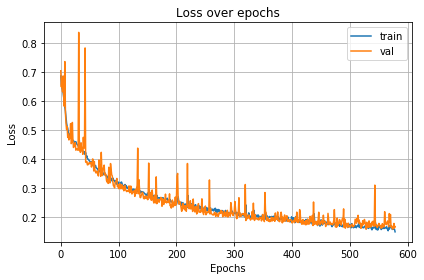

In [19]:
import numpy as np
import matplotlib.pyplot as plt

plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.grid(True, which='both', axis='both')

# plt.minorticks_on()
plt.tight_layout()

plt.legend()
plt.show()

plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.grid(True, which='both', axis='both')
plt.tight_layout()
plt.legend()
plt.show()

# # Plot training & validation accuracy values
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [20]:
from keras.models import load_model

model.save('eeg_eye_state_model_gru.h5')  # creates a HDF5 file 'my_model.h5'

# model = load_model('eeg_eye_state_model_gru.h5')


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = model.predict_classes(X_test)
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.945
Recall: 0.914
F1: 0.929


In [22]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
#print(confmat)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
# plt.savefig('./figures/confusion_matrix.png', dpi=300)
plt.show()

In [23]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 1
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2

plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

ROC AUC: 0.935
Accuracy: 0.937


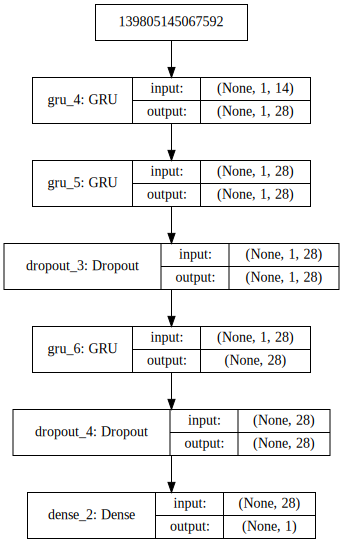

In [24]:
from keras.utils import plot_model
# plot_model(model, to_file='model.png')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))


In [25]:
from sklearn.metrics import classification_report
target_names = ['eye opened', 'eye closed']
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

              precision    recall  f1-score   support

  eye opened      0.931     0.956     0.944      1635
  eye closed      0.945     0.914     0.929      1344

   micro avg      0.937     0.937     0.937      2979
   macro avg      0.938     0.935     0.936      2979
weighted avg      0.937     0.937     0.937      2979



In [26]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred)

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.90')

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 1, 28)             3612      
_________________________________________________________________
gru_5 (GRU)                  (None, 1, 28)             4788      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 28)             0         
_________________________________________________________________
gru_6 (GRU)                  (None, 28)                4788      
_________________________________________________________________
dropout_4 (Dropout)          (None, 28)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 29        
Total params: 13,217
Trainable params: 13,217
Non-trainable params: 0
_________________________________________________________________
